<a href="https://colab.research.google.com/github/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/03_Batch_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch Prediction Pipeline

The main purpose of this notebook is to build KFP pipeline doing the following steps
1. Create an batch request input file (file list format) based on the files uploaded to a GCS bucket
2. Run Batch Prediction on the trained model obtained from [02_TFX_Training_Pipeline.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/02_TFX_Training_Pipeline.ipynb)
3. Measure the batch prediction model performance in terms of accuracy
4. If model performance < threshold
  - Copy the testing images to the original(previous) dataset
  - Trigger the TFX training pipeline with original data + newly added data

The functional test for batch prediction is shown in a separate notebook, [98_Batch_Prediction_Test.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/98_Batch_Prediction_Test.ipynb).

## Setup

In [2]:
!pip install fastdot
!pip install -q --upgrade google-cloud-aiplatform
!pip install -q --upgrade google-cloud-storage

     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 1.4 MB 7.2 MB/s 
     |████████████████████████████████| 105 kB 44.0 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 105 kB 66.7 MB/s 
     |████████████████████████████████| 105 kB 73.3 MB/s 
     |████████████████████████████████| 105 kB 67.8 MB/s 
     |████████████████████████████████| 104 kB 58.1 MB/s 
     |████████████████████████████████| 104 kB 70.1 MB/s 
     |████████████████████████████████| 103 kB 70.7 MB/s 
     |████████████████████████████████| 103 kB 72.5 MB/s 
     |████████████████████████████████| 103 kB 63.4 MB/s 
     |████████████████████████████████| 103 kB 87.0 MB/s 
     |████████████████████████████████| 97 kB 7.7 MB/s 
     |████████████████████████████████| 97 kB 7.6 MB/s 
     |████████████████████████████████| 97 kB 8.7 MB/s 
     |████████████████████████████████| 96 kB 6.0 MB/s 
     |█████████████████████

In [ ]:
!gcloud init

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Custom TFX Components

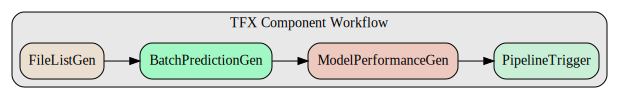

In [3]:
#@title
from fastdot.core import *

tfx_components = ['FileListGen', 'BatchPredictionGen', 'ModelPerformanceGen', 'PipelineTrigger']
block = 'TFX Component Workflow'

g = graph_items(seq_cluster(tfx_components, block))
g

### **FileListGen Component [OPTIONAL]**

- `FileListGen` will produce a `file list` file that `BatchPredictionGen` will refer to perform batch prediction on Vertex AI
- `file list` format can be found [here](https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions)

**Spec**
- input
  - GCS path where the raw files are
  - GCS path where the `file list` file will be 
- output
  - GCS path where the `file list` file is

### BatchPredictionGen Component
- Behaviour of `BatchPredictionGen` is similar to TFX standard component `BulkInferrer`.
- The only difference is we don't need `Model` artifact from `Trainer` but just `model ID` that can be found in `Vertex AI Model` registry.
- Predicted results will be fed into the `PerformanceEvaluator` component.

**Spec**
- input
  - GCS path where the TFRecord file is
  - model id from Vertex AI Model
- output
  - predictions

### **PerformanceEvaluator Component**
- Calculate any performance metrics 
- Outputs if the model performance is above or below the given threshold

**Spec**
- input
  - predictions
  - threshold
- output
  - `True` or `False` by the threshold

### PipelineTrigger Component
- Trigger the training pipeline based on the `True` or `False` value by the threshold

**Spec**
- input
  - `True` or `False` by threshold
  - pipeline name to be triggered
  - GCS path where the pipeline spec is 
  - GCP project ID
  - GCP region
- output
  - None